# Comparison Graphic
Demonstrating the benefits of using co-design as compared to traditional gripper designs, and visualization of changes over time.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
import os

### Model Selection

In [ ]:
# Get all the model files in the directory
evolution_runs = os.listdir("../logs/sb3/population_evolution/grasp_object/")
evolution_data = []
for run in evolution_runs:
    evolution_file = f"../logs/sb3/population_evolution/grasp_object/{run}/population_results.yaml"
    with open(evolution_file, 'r') as file:
        evolution_data.append(yaml.unsafe_load(file))

fixed_runs = os.listdir("../logs/sb3/Grasp-Object/")
fixed_data = []
for run in fixed_runs:
    fixed_file = f"../logs/sb3/Grasp-Object/{run}/perf_history.yaml"
    with open(fixed_file, 'r') as file:
        data = yaml.unsafe_load(file)
        fixed_data.append([val for val in data.values()])
fixed_data = np.array(fixed_data)

generation_count = evolution_data[0]["config"]["generations"]

### Data Analysis

In [74]:
# Find the top agents
top_agents = [{"top_agent": None, "performance_history": None, "length_history": None, "width_history": None, "rotation_history": None} for _ in range(len(evolution_data))]
for info, data in zip(top_agents, evolution_data):
    agents = {agent["id"]: agent for agent in data['agents']}
    top_agent = None
    top_agent_score = -np.inf
    for agent_id, agent in agents.items():
        if agent["best_fitness"] > top_agent_score:
            top_agent_score = agent["best_fitness"]
            top_agent = agent
    info["top_agent"] = top_agent

    # Find performance history
    performance_history = top_agent["fitness_history"].copy()
    for generation, parent_id in top_agent["family_tree"]:
        parent_agent = data['agents'][parent_id]
        performance_history.update({gen: value for gen, value in parent_agent["fitness_history"].items() if gen < generation})
    info["performance_history"] = performance_history

    # Map each generation to an agent id
    id_map = []
    prev_gen = 1
    for gen, parent_id in top_agent["family_tree"]:
        id_map += [parent_id for gen in range(prev_gen, gen+1)]
        prev_gen = gen+1
    id_map += [top_agent["id"] for gen in range(prev_gen, top_agent["generation"]+2)] # Account for -1 offset and exclusive range

    # Find the history of parameters 
    length_history = np.zeros((len(id_map), 3))
    width_history = np.zeros((len(id_map), 3))
    rotation_history = np.zeros((len(id_map), 3))
    for i, variant_id in enumerate(id_map):
        variant_params = np.array(agents[variant_id]["params"])
        length_history[i] = variant_params[:, 0]
        width_history[i] = variant_params[:, 1]
        rotation_history[i] = variant_params[:, 2]
    info["length_history"] = length_history
    info["width_history"] = width_history
    info["rotation_history"] = rotation_history

### Graphic Creation

In [75]:
# Prepare data for plotting
generations = [gen for gen in range(generation_count)]
fitness = [[] for _ in range(len(top_agents))]
for perf, agent in zip(fitness, top_agents):
    for gen in generations:
            if gen in agent["performance_history"]:
                perf.append(agent["performance_history"][gen])
            # Performance didn't increase after the last recorded generation
            else:
                 perf.append(perf[-1])
evo_fitness = np.array(fitness)

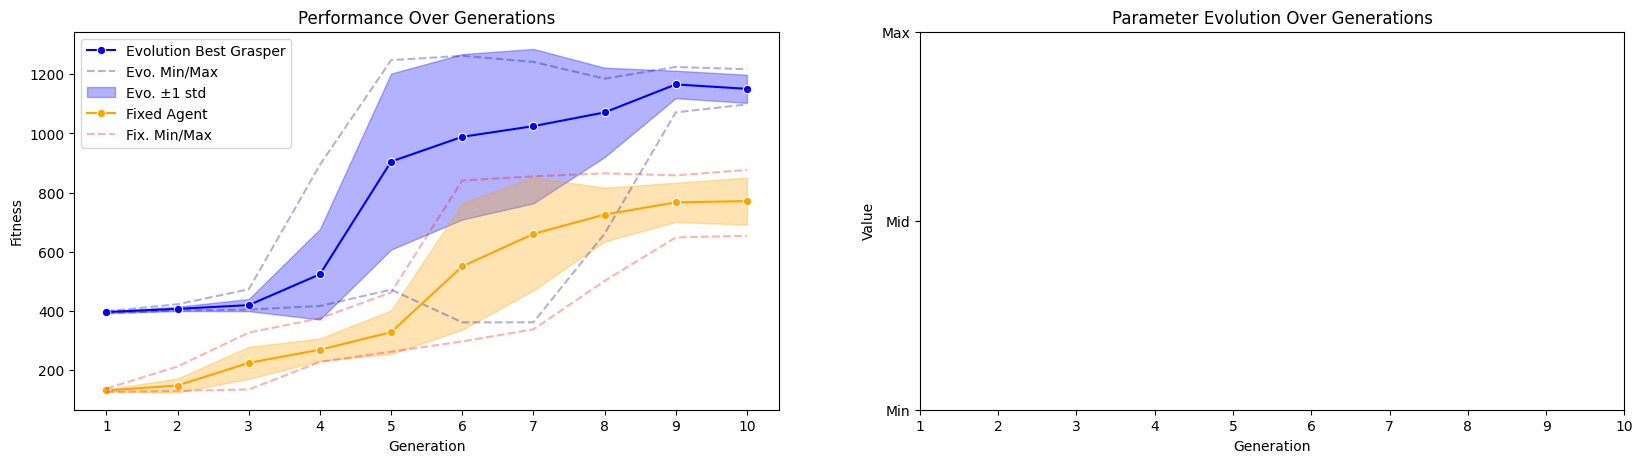

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fitness_ax = axes[0]
parameter_ax = axes[1]

# Add a vertical line at each mutation
# for gen, parent_id in top_agent["family_tree"]:
#     fitness_ax.axvline(x=gen-1, color='darkgray', linestyle='--', alpha=0.8)
#     parameter_ax.axvline(x=gen-1, color='darkgray', linestyle='--', alpha=0.8)

# Graph the lengths over time
# MIN_LENGTH = 0.3
# MAX_LENGTH = 2.0
# normalized_lengths = (length_history - MIN_LENGTH) / (MAX_LENGTH - MIN_LENGTH)
# for length in range(3):
#     sns.lineplot(
#         x=generations,
#         y=normalized_lengths[:, length],
#         label=f"Length {length+1}",
#         ax=parameter_ax,
#         linestyle=':',
#         color=plt.cm.Reds(0.5 + 0.25*length)
#     )

# # Graph the widths over time
# MIN_WIDTH = 0.1
# MAX_WIDTH = 1.0
# normalized_widths = (width_history - MIN_WIDTH) / (MAX_WIDTH - MIN_WIDTH)
# for width in range(3):
#     sns.lineplot(
#         x=generations,
#         y=normalized_widths[:, width], 
#         label=f"Width {width+1}", 
#         ax=parameter_ax, 
#         linestyle='--',
#         color=plt.cm.Greens(0.5 + 0.25*width)
#     )

# Graph the rotations over time
MIN_ROTATION = 0
MAX_ROTATION = 2*np.pi
normalized_rotations = (rotation_history - MIN_ROTATION) / (MAX_ROTATION - MIN_ROTATION)
# for rotation in range(3):
#     sns.lineplot(
#         x=generations,
#         y=normalized_rotations[:, rotation], 
#         label=f"Rotation {rotation+1}", 
#         ax=parameter_ax, 
#         linestyle='--',
#         color=plt.cm.Blues(0.3 + 0.3*rotation)
#     )


# Plot the performance history
evo_min, evo_max = np.min(evo_fitness, axis=0), np.max(evo_fitness, axis=0)
fix_min, fix_max = np.min(fixed_data, axis=0), np.max(fixed_data, axis=0)
evo_mean = np.mean(evo_fitness, axis=0)
evo_std = np.std(evo_fitness, axis=0)
fix_mean = np.mean(fixed_data, axis=0)
fix_std = np.std(fixed_data, axis=0)
sns.lineplot(x=generations, y=evo_mean, marker="o", ax=fitness_ax, label="Evolution Best Grasper", color='blue')
sns.lineplot(x=generations, y=evo_max, linestyle="--", ax=fitness_ax, color='darkblue', alpha=0.3, label="Evo. Min/Max")
sns.lineplot(x=generations, y=evo_min, linestyle="--", ax=fitness_ax, color='darkblue', alpha=0.3)
fitness_ax.fill_between(x=generations, y1=evo_mean - evo_std, y2=evo_mean + evo_std, alpha=0.3, label="Evo. ±1 std", color='blue')
sns.lineplot(x=generations, y=fix_mean, errorbar="sd", marker="o", ax=fitness_ax, color='orange', label='Fixed Agent')
sns.lineplot(x=generations, y=fix_max, linestyle="--", ax=fitness_ax, color='red', alpha=0.3, label="Fix. Min/Max")
sns.lineplot(x=generations, y=fix_min, linestyle="--", ax=fitness_ax, color='red', alpha=0.3)
fitness_ax.fill_between(x=generations, y1=fix_mean - fix_std, y2=fix_mean + fix_std, alpha=0.3, label="Fix. ±1 std", color='orange')

fitness_ax.set_xlabel("Generation")
parameter_ax.set_xlabel("Generation")
fitness_ax.set_ylabel("Fitness")
parameter_ax.set_ylabel("Value")
fitness_ax.set_title("Performance Over Generations")
parameter_ax.set_title("Parameter Evolution Over Generations")

fitness_ax.set_xticks(generations, labels=[g+1 for g in generations])
parameter_ax.set_xticks(generations, labels=[g+1 for g in generations])
parameter_ax.set_yticks([0, 0.5, 1.0])
parameter_ax.set_yticklabels(['Min', 'Mid', 'Max'])

# Reserve space below for images
plt.subplots_adjust(bottom=0.25)  # Adjust as needed for image space

# # Add images along the bottom of the figure
# image_dir = "../diagrams/diagram_snapshots"
# image_files = sorted(os.listdir(image_dir))
# image_files = [f for f in image_files if f.endswith('.png')]
# image_count = len(image_files)
# image_width = 0.1  # Width of each image in the figure
# image_height = 0.1  # Height of each image in the figure
# for i, image_file in enumerate(image_files):
#     img_path = os.path.join(image_dir, image_file)
#     img = plt.imread(img_path)
#     ax = fig.add_axes([i * image_width, -0.10, image_width, image_height])  # Adjust y position as needed
#     # Resize image to fit the axes exactly
#     ax.imshow(img, aspect='equal', extent=[0, 1, 0, 1])
#     ax.axis('off')  # Hide axes for images

plt.show()